In [1]:
import pandas as pd
import numpy as np
import joblib
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Încărcarea datasetului
df = pd.read_csv('clean_dataset_Romania.csv')

# Codificarea one-hot
df = pd.get_dummies(df, columns=['type', 'region', 'room_type'])

# Creează o listă cu numele coloanelor codificate cu one-hot
one_hot_columns = [col for col in df.columns if 'type_' in col or 'region_' in col or 'room_type_' in col]

# Adaugă coloanele predefinite la listă
selected_columns = one_hot_columns + [
    'persons', 'stars', 'mic_dejun', 'nota_personal', 'nota_facilităţi', 'nota_curăţenie',
    'nota_confort', 'nota_raport_calitate/preţ', 'nota_locaţie', 'nota_wifi_gratuit', 'num_reviews',
    'vedere_la_oraș', 'menaj_zilnic', 'canale_prin_satelit', 'zonă_de_luat_masa_în_aer_liber', 'cadă',
    'facilităţi_de_călcat', 'izolare_fonică', 'terasă_la_soare', 'pardoseală_de_gresie/marmură',
    'papuci_de_casă', 'uscător_de_rufe', 'animale_de_companie', 'încălzire', 'birou', 'mobilier_exterior',
    'alarmă_de_fum', 'vedere_la_grădină', 'cuptor', 'cuptor_cu_microunde', 'zonă_de_relaxare', 'canapea',
    'intrare_privată', 'fier_de_călcat', 'mașină_de_cafea', 'plită_de_gătit', 'extinctoare', 'cană_fierbător',
    'grădină', 'ustensile_de_bucătărie', 'maşină_de_spălat', 'balcon', 'pardoseală_de_lemn_sau_parchet',
    'aparat_pentru_prepararea_de_ceai/cafea', 'zonă_de_luat_masa', 'canale_prin_cablu', 'aer_condiţionat',
    'masă', 'suport_de_haine', 'cadă_sau_duş', 'frigider'
]

# Selectează doar coloanele dorite din DataFrame
features = df[selected_columns]
target = df['price']

# Împărțirea datelor în seturi de antrenament și testare
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Selectarea caracteristicilor și a țintei pentru fiecare set de date
features_train = df_train[features.columns]
target_train = df_train['price']

features_test = df_test[features.columns]
target_test = df_test['price']

# Crearea imputerului pentru a înlocui valorile lipsă
imputer = SimpleImputer(strategy='mean')

features_train = imputer.fit_transform(features_train)
features_test = imputer.transform(features_test)

# Eliminare Outlieri
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df_optimized = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]

# Antrenare model pe datele curățate
features_optimized = df_optimized[selected_columns]
target_optimized = df_optimized['price']

# Împărțirea datelor în seturi de antrenament și testare
features_train_optimized, features_test_optimized, target_train_optimized, target_test_optimized = train_test_split(
    features_optimized, target_optimized, test_size=0.2, random_state=0
)

# Normalizare și scalare
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train_optimized)
features_test_scaled = scaler.transform(features_test_optimized)

In [ ]:
# Extrage numele coloanelor
column_names = features.columns.tolist()

# Salvează numele coloanelor într-un fișier text
with open('nume_coloane.txt', 'w') as file:
    for col_name in column_names:
        file.write(col_name + '\n')

print("Numele coloanelor au fost salvate în fișierul nume_coloane.txt.")

Numele coloanelor au fost salvate în fișierul nume_coloane.txt.


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Crearea modelului
model_optimized = LinearRegression()
model = LinearRegression()

# Antrenarea modelului pe datele optimizate
model_optimized.fit(features_train_optimized, target_train_optimized)

# Antrenarea modelului pe datele originale (neoptimizate)
model.fit(features_train, target_train)

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_optimized = model_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test = model.predict(features_test)

# Evaluarea modelului pe datele de testare optimizate
print('Eroare absolută medie (LinearRegression, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_optimized))
print('Eroare pătratică medie (LinearRegression, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_optimized))
print('Rădăcina erorii pătratice medii (LinearRegression, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_optimized)))

# Evaluarea modelului pe setul de testare original
print('\nEroare absolută medie (LinearRegression, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test))
print('Eroare pătratică medie (LinearRegression, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test))
print('Rădăcina erorii pătratice medii (LinearRegression, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test)))

# Crearea unui DataFrame cu caracteristicile de antrenament
features_df = pd.DataFrame(features_train, columns=features.columns)

# Identificarea coloanelor numerice
numeric_columns = features_df.select_dtypes(include=[np.number]).columns

# Extrage coeficienții de regresie
coefficients = pd.DataFrame(zip(numeric_columns, model.coef_), columns=['Feature', 'Coefficient'])

# Ordonează coeficienții în ordine descrescătoare
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Salvează coeficienții într-un fișier text
with open('coeficienti.txt', 'w') as file:
    for coefficient in coefficients.values:
        file.write(f'{coefficient[0]}, {coefficient[1]}\n')

print("Numele coloanelor au fost salvate în fișierul coeficienti.txt.")

# Extrage interceptul
print("Intercept:", model.intercept_)

Eroare absolută medie (LinearRegression, Optimizat): 70.99181108236554
Eroare pătratică medie (LinearRegression, Optimizat): 8657.732622639984
Rădăcina erorii pătratice medii (LinearRegression, Optimizat): 93.04693773918615

Eroare absolută medie (LinearRegression, Neoptimizat): 462336053.50962675
Eroare pătratică medie (LinearRegression, Neoptimizat): 5.606343107154856e+19
Rădăcina erorii pătratice medii (LinearRegression, Neoptimizat): 7487551740.82614
Numele coloanelor au fost salvate în fișierul coeficienti.txt.
Intercept: -22393043528.1846


In [3]:
from sklearn.linear_model import Lasso

# Crearea modelului Lasso
model_lasso_optimized = Lasso(alpha=0.1)
model_lasso = Lasso(alpha=0.1)

# Antrenarea modelului Lasso pe datele optimizate
model_lasso_optimized.fit(features_train_optimized, target_train_optimized)

# Antrenarea modelului Lasso pe datele originale (neoptimizate)
model_lasso.fit(features_train, target_train)

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_lasso_optimized = model_lasso_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test_lasso = model_lasso.predict(features_test)

# Evaluarea modelului Lasso pe datele de testare optimizate
print('Eroare absolută medie (Lasso, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_lasso_optimized))
print('Eroare pătratică medie (Lasso, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_lasso_optimized))
print('Rădăcina erorii pătratice medii (Lasso, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_lasso_optimized)))

# Evaluarea modelului Lasso pe setul de testare original
print('\nEroare absolută medie (Lasso, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test_lasso))
print('Eroare pătratică medie (Lasso, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test_lasso))
print('Rădăcina erorii pătratice medii (Lasso, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test_lasso)))


Eroare absolută medie (Lasso, Optimizat): 70.77396508667208
Eroare pătratică medie (Lasso, Optimizat): 8734.565891116788
Rădăcina erorii pătratice medii (Lasso, Optimizat): 93.45889947520668

Eroare absolută medie (Lasso, Neoptimizat): 81.66748058847494
Eroare pătratică medie (Lasso, Neoptimizat): 13041.207198274695
Rădăcina erorii pătratice medii (Lasso, Neoptimizat): 114.19810505553363


In [4]:
from sklearn.linear_model import ElasticNet

# Crearea modelului ElasticNet
model_enet_optimized = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_enet = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Antrenarea modelului ElasticNet pe datele optimizate
model_enet_optimized.fit(features_train_optimized, target_train_optimized)

# Antrenarea modelului ElasticNet pe datele originale (neoptimizate)
model_enet.fit(features_train, target_train)

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_enet_optimized = model_enet_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test_enet = model_enet.predict(features_test)

# Evaluarea modelului ElasticNet pe datele de testare optimizate
print('Eroare absolută medie (ElasticNet, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_enet_optimized))
print('Eroare pătratică medie (ElasticNet, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_enet_optimized))
print('Rădăcina erorii pătratice medii (ElasticNet, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_enet_optimized)))

# Evaluarea modelului ElasticNet pe setul de testare original
print('\nEroare absolută medie (ElasticNet, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test_enet))
print('Eroare pătratică medie (ElasticNet, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test_enet))
print('Rădăcina erorii pătratice medii (ElasticNet, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test_enet)))


Eroare absolută medie (ElasticNet, Optimizat): 73.31159906533523
Eroare pătratică medie (ElasticNet, Optimizat): 8831.783667172498
Rădăcina erorii pătratice medii (ElasticNet, Optimizat): 93.97757002164133

Eroare absolută medie (ElasticNet, Neoptimizat): 85.62382121400552
Eroare pătratică medie (ElasticNet, Neoptimizat): 14215.086402689902
Rădăcina erorii pătratice medii (ElasticNet, Neoptimizat): 119.2270372134186


In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

# Crearea modelului
model_tree_optimized = DecisionTreeRegressor(random_state=0)
model_tree = DecisionTreeRegressor(random_state=0)

# Antrenarea modelului pe datele optimizate
model_tree_optimized.fit(features_train_optimized, target_train_optimized)

# Antrenarea modelului pe datele originale (neoptimizate)
model_tree.fit(features_train, target_train)

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_tree_optimized = model_tree_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test_tree = model_tree.predict(features_test)

# Evaluarea modelului pe datele de testare optimizate
print('Eroare absolută medie (DecisionTreeRegressor, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_tree_optimized))
print('Eroare pătratică medie (DecisionTreeRegressor, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_tree_optimized))
print('Rădăcina erorii pătratice medii (DecisionTreeRegressor, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_tree_optimized)))

# Evaluarea modelului pe setul de testare original
print('\nEroare absolută medie (DecisionTreeRegressor, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test_tree))
print('Eroare pătratică medie (DecisionTreeRegressor, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test_tree))
print('Rădăcina erorii pătratice medii (DecisionTreeRegressor, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test_tree)))
print('\n')
# + scara de valori sau transformare in procent
# Obținerea importanței caracteristicilor
feature_importances = model_tree.feature_importances_

# Creează o funcție care extrage numele de bază al coloanei
def extract_base_name(col_name):
    # Extrage numele de bază al coloanei
    if '_' in col_name:
        base_name = col_name.split('_')[0]
    else:
        base_name = col_name
    return base_name

# Crearea unui DataFrame pentru a afișa importanța fiecărei caracteristici
df_importance = pd.DataFrame({
    'Facilitate': features.columns,
    'Importanta': feature_importances
})

# Aplică funcția la coloana 'Facilitate'
df_importance['Facilitate'] = df_importance['Facilitate'].apply(extract_base_name)

# Gruparea DataFrame-ului după 'Facilitate' și calcularea importanței maxime pentru fiecare grup
df_importance = df_importance.groupby('Facilitate').max()

# Resetează indexul DataFrame-ului
df_importance = df_importance.reset_index()

# Sortarea caracteristicilor în funcție de importanța lor
df_importance = df_importance.sort_values(by='Importanta', ascending=False)

# Afișarea caracteristicilor sortate după importanța lor
print(df_importance)


Eroare absolută medie (DecisionTreeRegressor, Optimizat): 97.36761904761904
Eroare pătratică medie (DecisionTreeRegressor, Optimizat): 17183.989523809523
Rădăcina erorii pătratice medii (DecisionTreeRegressor, Optimizat): 131.0877169066939

Eroare absolută medie (DecisionTreeRegressor, Neoptimizat): 111.38112522686025
Eroare pătratică medie (DecisionTreeRegressor, Neoptimizat): 25165.66606170599
Rădăcina erorii pătratice medii (DecisionTreeRegressor, Neoptimizat): 158.6369000633396


     Facilitate  Importanta
28      persons    0.145317
32        stars    0.108180
25          num    0.048652
24         nota    0.037391
30       region    0.030562
1        alarmă    0.023769
31         room    0.015943
20       mașină    0.014741
11  extinctoare    0.013605
35         type    0.013082
7        canale    0.013080
15      grădină    0.012515
8       canapea    0.012358
23     mobilier    0.009317
2       animale    0.009033
38       vedere    0.008821
19       maşină    0.008698
9      

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Crearea modelului
model_xgb_optimized = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0)
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0)

# Antrenarea modelului pe datele optimizate
model_xgb_optimized.fit(features_train_optimized, target_train_optimized)

# Antrenarea modelului pe datele originale (neoptimizate)
model_xgb.fit(features_train, target_train)

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_xgb_optimized = model_xgb_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test_xgb = model_xgb.predict(features_test)

# Evaluarea modelului pe datele de testare optimizate
print('Eroare absolută medie (XGBoost, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_xgb_optimized))
print('Eroare pătratică medie (XGBoost, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_xgb_optimized))
print('Rădăcina erorii pătratice medii (XGBoost, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_xgb_optimized)))

# Evaluarea modelului pe setul de testare original
print('\nEroare absolută medie (XGBoost, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test_xgb))
print('Eroare pătratică medie (XGBoost, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test_xgb))
print('Rădăcina erorii pătratice medii (XGBoost, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test_xgb)))


Eroare absolută medie (XGBoost, Optimizat): 70.8658256312779
Eroare pătratică medie (XGBoost, Optimizat): 8611.000239468845
Rădăcina erorii pătratice medii (XGBoost, Optimizat): 92.7954753178669

Eroare absolută medie (XGBoost, Neoptimizat): 79.04627705485764
Eroare pătratică medie (XGBoost, Neoptimizat): 12250.626161916509
Rădăcina erorii pătratice medii (XGBoost, Neoptimizat): 110.68254678094695


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Crearea modelului
model_ridge = Ridge()

# Definirea grilei de căutare pentru hiperparametri
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Inițializarea grid search
grid_search = GridSearchCV(model_ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

# Antrenarea modelului cu grid search
grid_search.fit(features_train_optimized, target_train_optimized)

# Crearea modelului cu cei mai buni hiperparametri
model_ridge_optimized = Ridge(alpha=grid_search.best_params_['alpha'])
model_ridge = Ridge(alpha=grid_search.best_params_['alpha'])

# Antrenarea modelului pe datele optimizate
model_ridge_optimized.fit(features_train_optimized, target_train_optimized)

# Antrenarea modelului pe datele originale (neoptimizate)
model_ridge.fit(features_train, target_train)

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_ridge_optimized = model_ridge_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test_ridge = model_ridge.predict(features_test)

# Evaluarea modelului pe datele de testare optimizate
print('Eroare absolută medie (Ridge, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_ridge_optimized))
print('Eroare pătratică medie (Ridge, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_ridge_optimized))
print('Rădăcina erorii pătratice medii (Ridge, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_ridge_optimized)))

# Evaluarea modelului pe setul de testare original
print('\nEroare absolută medie (Ridge, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test_ridge))
print('Eroare pătratică medie (Ridge, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test_ridge))
print('Rădăcina erorii pătratice medii (Ridge, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test_ridge)))


Eroare absolută medie (Ridge, Optimizat): 70.60291949903318
Eroare pătratică medie (Ridge, Optimizat): 8590.091603122646
Rădăcina erorii pătratice medii (Ridge, Optimizat): 92.68274706288462

Eroare absolută medie (Ridge, Neoptimizat): 82.10475945658509
Eroare pătratică medie (Ridge, Neoptimizat): 13193.421271946783
Rădăcina erorii pătratice medii (Ridge, Neoptimizat): 114.86261912365913


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Crearea modelului
model_rf_optimized = RandomForestRegressor(random_state=0)
model_rf = RandomForestRegressor(random_state=0)

# Antrenarea modelului pe datele optimizate
model_rf_optimized.fit(features_train_optimized, target_train_optimized.ravel())

# Antrenarea modelului pe datele originale (neoptimizate)
model_rf.fit(features_train, target_train.ravel())

# Realizarea predicțiilor pe datele de testare optimizate
target_predicted_test_rf_optimized = model_rf_optimized.predict(features_test_optimized)

# Efectuarea de predicții pe setul de testare original
target_predicted_test_rf = model_rf.predict(features_test)

# Evaluarea modelului pe datele de testare optimizate
print('Eroare absolută medie (Random Forest, Optimizat):', metrics.mean_absolute_error(target_test_optimized, target_predicted_test_rf_optimized))
print('Eroare pătratică medie (Random Forest, Optimizat):', metrics.mean_squared_error(target_test_optimized, target_predicted_test_rf_optimized))
print('Rădăcina erorii pătratice medii (Random Forest, Optimizat):', np.sqrt(metrics.mean_squared_error(target_test_optimized, target_predicted_test_rf_optimized)))

# Evaluarea modelului pe setul de testare original
print('\nEroare absolută medie (Random Forest, Neoptimizat):', metrics.mean_absolute_error(target_test, target_predicted_test_rf))
print('Eroare pătratică medie (Random Forest, Neoptimizat):', metrics.mean_squared_error(target_test, target_predicted_test_rf))
print('Rădăcina erorii pătratice medii (Random Forest, Neoptimizat):', np.sqrt(metrics.mean_squared_error(target_test, target_predicted_test_rf)))

# Salvarea și descărcarea modelului Random Forest optimizat
#joblib.dump(model_rf_optimized, 'price_predict_rf_optimized.pkl')
#files.download('price_predict_rf_optimized.pkl')

Eroare absolută medie (Random Forest, Optimizat): 69.9713290929705
Eroare pătratică medie (Random Forest, Optimizat): 8265.53261384647
Rădăcina erorii pătratice medii (Random Forest, Optimizat): 90.91497464030043

Eroare absolută medie (Random Forest, Neoptimizat): 80.11557039149598
Eroare pătratică medie (Random Forest, Neoptimizat): 12204.721957244994
Rădăcina erorii pătratice medii (Random Forest, Neoptimizat): 110.47498340006662


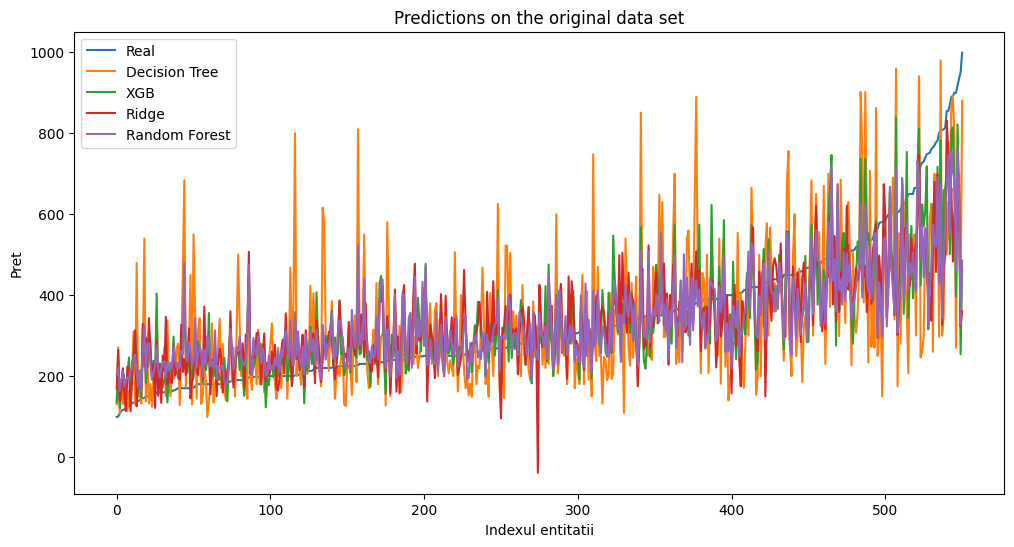

Eroarea medie procentuală absolută pentru Decision Tree (Original): 34.75008968043486
Eroarea medie procentuală absolută pentru XGBoost (Original): 24.873537916373113
Eroarea medie procentuală absolută pentru Ridge (Original): 26.12327102675151
Eroarea medie procentuală absolută pentru Random Forest (Original): 25.60820731687053




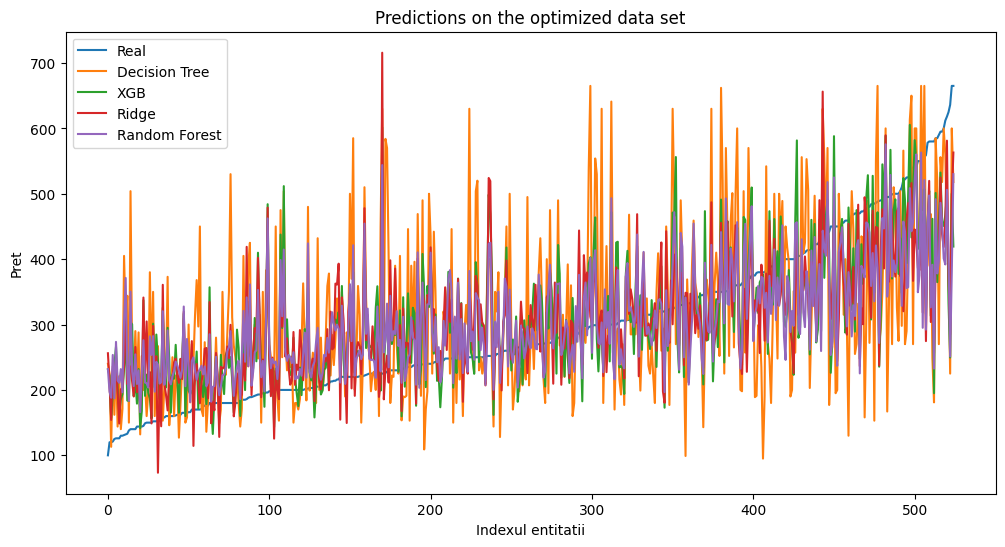


Eroarea medie procentuală absolută pentru Decision Tree (Optimizat): 36.11809173378609
Eroarea medie procentuală absolută pentru XGBoost (Optimizat): 26.409661922045537
Eroarea medie procentuală absolută pentru Ridge (Optimizat): 26.536153082622494
Eroarea medie procentuală absolută pentru Random Forest (Optimizat): 26.356617103090933


In [9]:
import matplotlib.pyplot as plt

# Antrenarea modelelor pe datele originale
model_tree.fit(features_train, target_train)
model_xgb.fit(features_train, target_train)
model_ridge.fit(features_train, target_train)
model_rf.fit(features_train, target_train)

# Realizarea predicțiilor cu toate modelele pe setul de date original
prices_predicted_tree = model_tree.predict(features_test)
prices_predicted_xgb = model_xgb.predict(features_test)
prices_predicted_ridge = model_ridge.predict(features_test)
prices_predicted_rf = model_rf.predict(features_test)

# Antrenarea modelelor pe datele optimizate
model_tree_optimized.fit(features_train_optimized, target_train_optimized)
model_xgb_optimized.fit(features_train_optimized, target_train_optimized)
model_ridge_optimized.fit(features_train_optimized, target_train_optimized)
model_rf_optimized.fit(features_train_optimized, target_train_optimized)

# Realizarea predicțiilor cu toate modelele pe setul de date optimizat
prices_predicted_tree_optimized = model_tree_optimized.predict(features_test_optimized)
prices_predicted_xgb_optimized = model_xgb_optimized.predict(features_test_optimized)
prices_predicted_ridge_optimized = model_ridge_optimized.predict(features_test_optimized)
prices_predicted_rf_optimized = model_rf_optimized.predict(features_test_optimized)

# Crearea unui DataFrame cu prețurile reale și predicțiile pentru setul de date optimizat
df_plot = pd.DataFrame({
    'Real': target_test,
    'Decision Tree': prices_predicted_tree,
    'XGB': prices_predicted_xgb,
    'Ridge': prices_predicted_ridge,
    'Random Forest': prices_predicted_rf
})

# Sortarea entităților după prețul real în ordine crescătoare pentru setul de date optimizat
df_plot = df_plot.sort_values('Real')

# Resetarea indexului pentru setul de date optimizat
df_plot = df_plot.reset_index(drop=True)

# Crearea unui DataFrame cu prețurile reale și predicțiile pentru setul de date optimizat
df_plot_optimized = pd.DataFrame({
    'Real': target_test_optimized,
    'Decision Tree': prices_predicted_tree_optimized,
    'XGB': prices_predicted_xgb_optimized,
    'Ridge': prices_predicted_ridge_optimized,
    'Random Forest': prices_predicted_rf_optimized
})

# Sortarea entităților după prețul real în ordine crescătoare pentru setul de date optimizat
df_plot_optimized = df_plot_optimized.sort_values('Real')

# Resetarea indexului pentru setul de date optimizat
df_plot_optimized = df_plot_optimized.reset_index(drop=True)

# Crearea graficelor pentru setul de date original
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Real'], label='Real')
plt.plot(df_plot['Decision Tree'], label='Decision Tree')
plt.plot(df_plot['XGB'], label='XGB')
plt.plot(df_plot['Ridge'], label='Ridge')
plt.plot(df_plot['Random Forest'], label='Random Forest')
plt.xlabel('Indexul entitatii')
plt.ylabel('Pret')
plt.legend()
plt.title('Predictions on the original data set')
plt.show()

# Calcularea erorii medii procentuale absolute (MAPE) pentru fiecare model pe setul de date original
mape_tree = 100 * np.mean(np.abs((target_test - prices_predicted_tree) / target_test))
print('Eroarea medie procentuală absolută pentru Decision Tree (Original):', mape_tree)

mape_xgb = 100 * np.mean(np.abs((target_test - prices_predicted_xgb) / target_test))
print('Eroarea medie procentuală absolută pentru XGBoost (Original):', mape_xgb)

mape_ridge = 100 * np.mean(np.abs((target_test - prices_predicted_ridge) / target_test))
print('Eroarea medie procentuală absolută pentru Ridge (Original):', mape_ridge)

mape_rf = 100 * np.mean(np.abs((target_test - prices_predicted_rf) / target_test))
print('Eroarea medie procentuală absolută pentru Random Forest (Original):', mape_rf)
print('\n')

# Crearea graficelor pentru setul de date optimizat
plt.figure(figsize=(12, 6))
plt.plot(df_plot_optimized['Real'], label='Real')
plt.plot(df_plot_optimized['Decision Tree'], label='Decision Tree')
plt.plot(df_plot_optimized['XGB'], label='XGB')
plt.plot(df_plot_optimized['Ridge'], label='Ridge')
plt.plot(df_plot_optimized['Random Forest'], label='Random Forest')
plt.xlabel('Indexul entitatii')
plt.ylabel('Pret')
plt.legend()
plt.title('Predictions on the optimized data set')
plt.show()
# Calcularea erorii medii procentuale absolute (MAPE) pentru fiecare model pe setul de date optimizat
mape_tree_optimized = 100 * np.mean(np.abs((target_test_optimized - prices_predicted_tree_optimized) / target_test_optimized))
print('\nEroarea medie procentuală absolută pentru Decision Tree (Optimizat):', mape_tree_optimized)

mape_xgb_optimized = 100 * np.mean(np.abs((target_test_optimized - prices_predicted_xgb_optimized) / target_test_optimized))
print('Eroarea medie procentuală absolută pentru XGBoost (Optimizat):', mape_xgb_optimized)

mape_ridge_optimized = 100 * np.mean(np.abs((target_test_optimized - prices_predicted_ridge_optimized) / target_test_optimized))
print('Eroarea medie procentuală absolută pentru Ridge (Optimizat):', mape_ridge_optimized)

mape_rf_optimized = 100 * np.mean(np.abs((target_test_optimized - prices_predicted_rf_optimized) / target_test_optimized))
print('Eroarea medie procentuală absolută pentru Random Forest (Optimizat):', mape_rf_optimized)

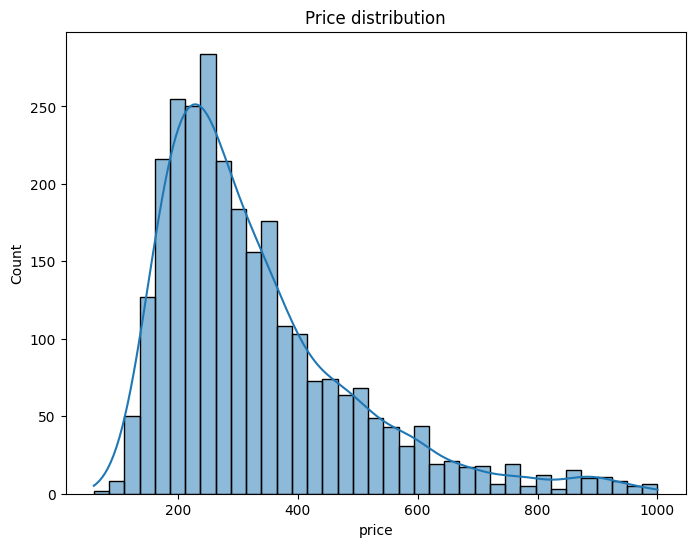

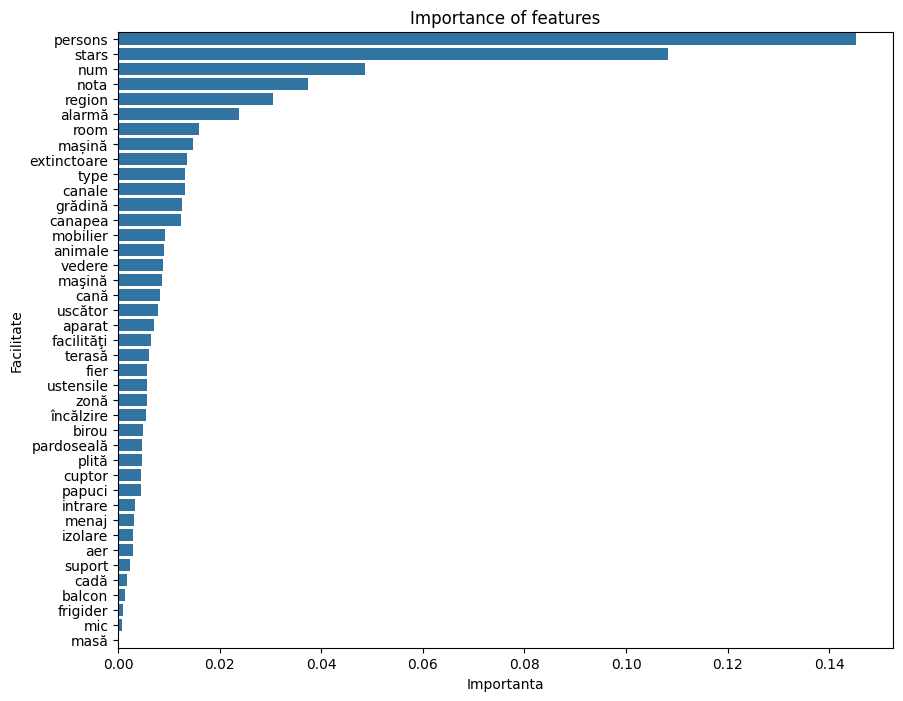

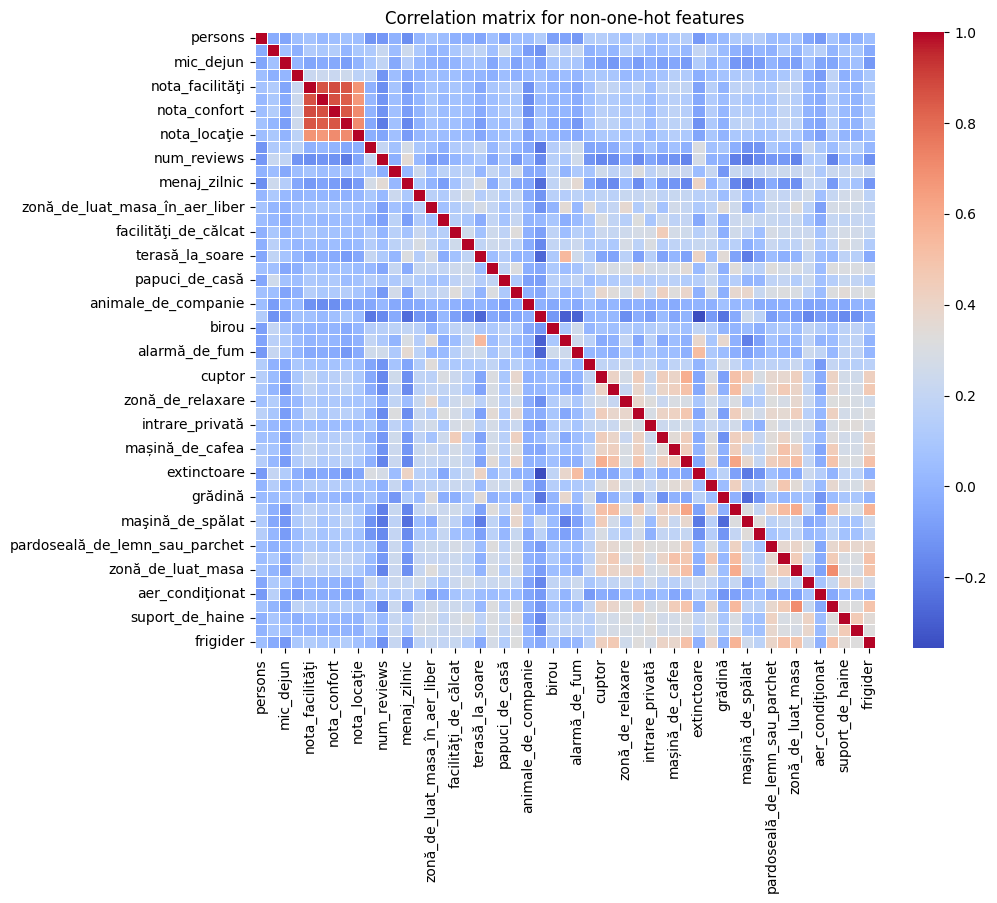

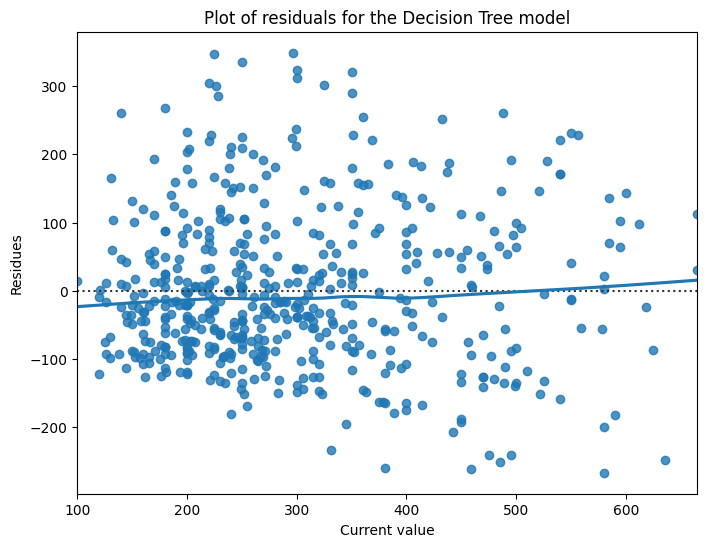

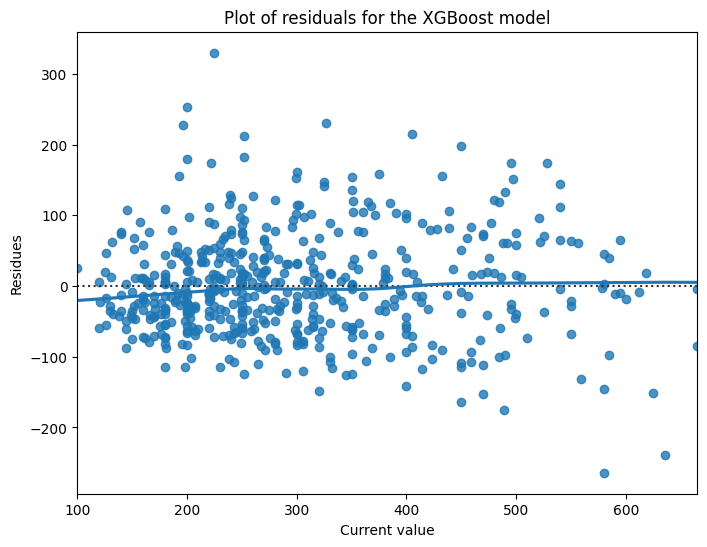

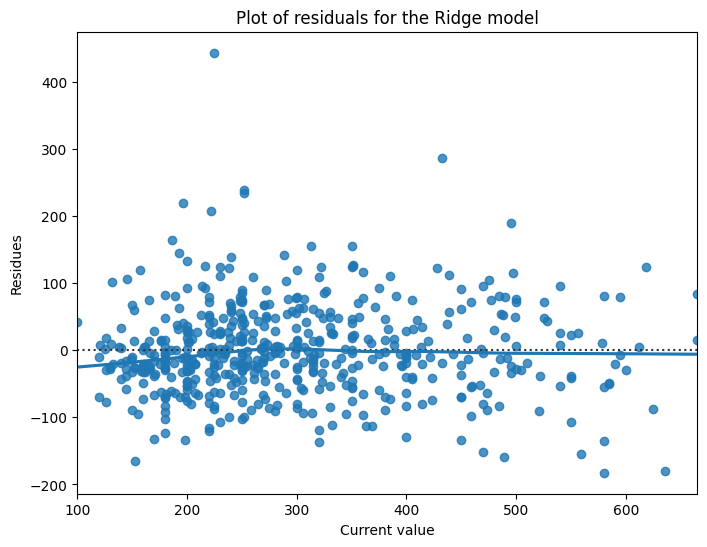

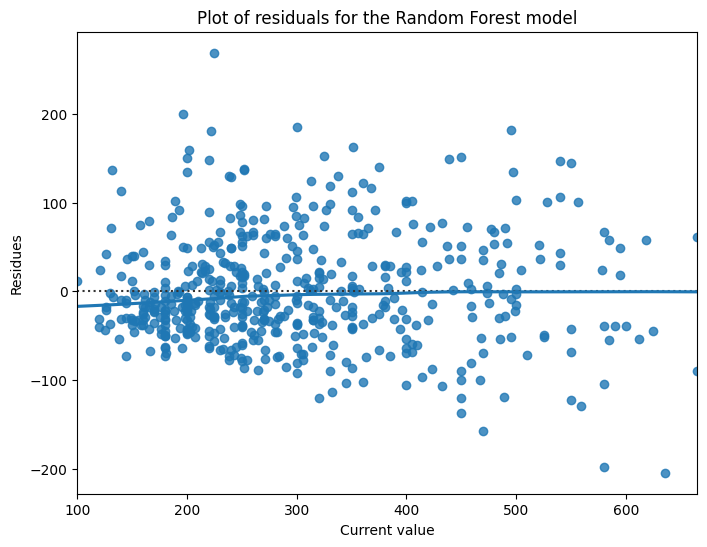

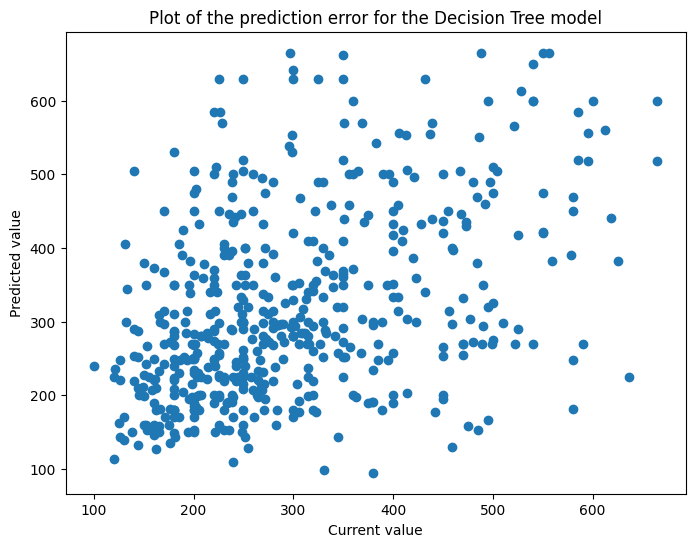

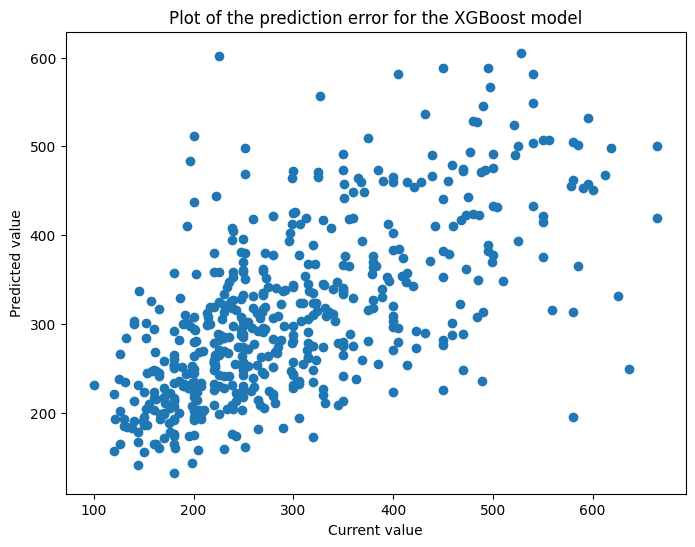

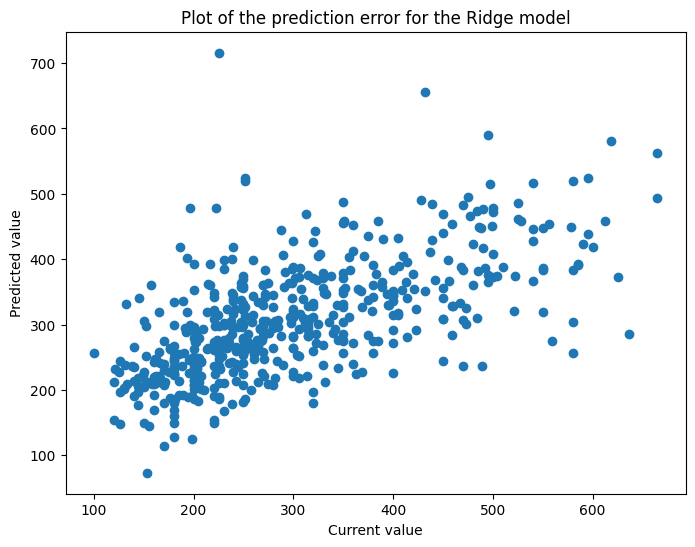

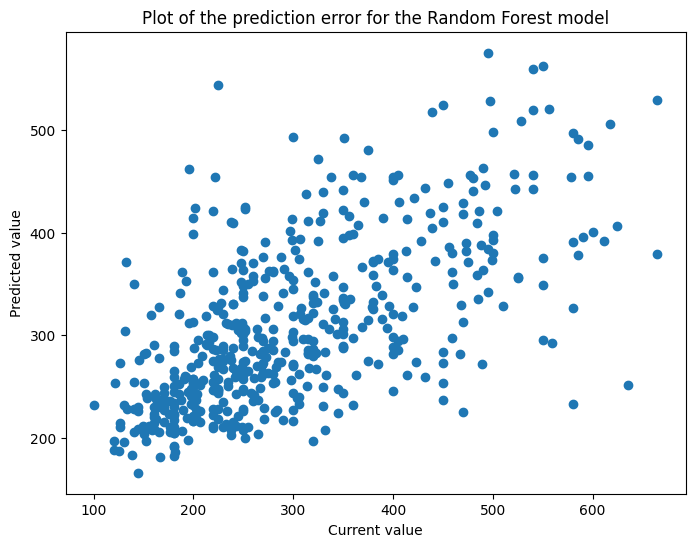

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Histograma pentru variabila tinta
plt.figure(figsize=(8,6))
sns.histplot(df['price'], kde=True)
plt.title('Price distribution')
plt.show()

# Importanța caracteristicilor
plt.figure(figsize=(10,8))
sns.barplot(x='Importanta', y='Facilitate', data=df_importance)
plt.title('Importance of features')
plt.show()

# Selectează doar coloanele care nu sunt codificate cu one-hot din DataFrame
non_one_hot_columns = [col for col in features.columns if col not in one_hot_columns]

# Creează o nouă matrice de date cu doar caracteristicile non-one-hot
features_non_one_hot = df[non_one_hot_columns]

# Calculează matricea de corelație doar pentru caracteristicile non-one-hot
correlation_matrix_non_one_hot = features_non_one_hot.corr()

# Afișează matricea de corelație doar pentru cele mai importante 15 atribute
correlation_matrix=df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_non_one_hot, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation matrix for non-one-hot features')
plt.show()

# Plotul reziduurilor pentru modelul de arbore de decizie
plt.figure(figsize=(8,6))
sns.residplot(x=target_test_optimized, y=target_predicted_test_tree_optimized.flatten(), lowess=True)
plt.title('Plot of residuals for the Decision Tree model')
plt.xlabel('Current value')
plt.ylabel('Residues')
plt.show()

# Plotul reziduurilor pentru modelul XGBoost
plt.figure(figsize=(8,6))
sns.residplot(x=target_test_optimized, y=target_predicted_test_xgb_optimized.flatten(), lowess=True)
plt.title('Plot of residuals for the XGBoost model')
plt.xlabel('Current value')
plt.ylabel('Residues')
plt.show()

# Plotul reziduurilor pentru modelul Ridge
plt.figure(figsize=(8,6))
sns.residplot(x=target_test_optimized, y=target_predicted_test_ridge_optimized.flatten(), lowess=True)
plt.title('Plot of residuals for the Ridge model')
plt.xlabel('Current value')
plt.ylabel('Residues')
plt.show()

# Plotul reziduurilor pentru modelul Random Forest
plt.figure(figsize=(8,6))
sns.residplot(x=target_test_optimized, y=target_predicted_test_rf_optimized.flatten(), lowess=True)
plt.title('Plot of residuals for the Random Forest model')
plt.xlabel('Current value')
plt.ylabel('Residues')
plt.show()

# Plotul erorii de predicție pentru modelul de arbore de decizie
plt.figure(figsize=(8,6))
plt.scatter(target_test_optimized, target_predicted_test_tree_optimized)
plt.title('Plot of the prediction error for the Decision Tree model')
plt.xlabel('Current value')
plt.ylabel('Predicted value')
plt.show()

# Plotul erorii de predicție pentru modelul XGBoost
plt.figure(figsize=(8,6))
plt.scatter(target_test_optimized, target_predicted_test_xgb_optimized)
plt.title('Plot of the prediction error for the XGBoost model')
plt.xlabel('Current value')
plt.ylabel('Predicted value')
plt.show()

# Plotul erorii de predicție pentru modelul Ridge
plt.figure(figsize=(8,6))
plt.scatter(target_test_optimized, target_predicted_test_ridge_optimized)
plt.title('Plot of the prediction error for the Ridge model')
plt.xlabel('Current value')
plt.ylabel('Predicted value')
plt.show()

# Plotul erorii de predicție pentru modelul Random Forest
plt.figure(figsize=(8,6))
plt.scatter(target_test_optimized, target_predicted_test_rf_optimized)
plt.title('Plot of the prediction error for the Random Forest model')
plt.xlabel('Current value')
plt.ylabel('Predicted value')
plt.show()